In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import csv
from tqdm import tqdm
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

### Data Pre-processing

In [2]:
movies = pd.read_csv('data/movies.csv')
ratings = pd.read_csv('data/ratings.csv', low_memory=False)

In [3]:
# Merge the datasets
df = pd.merge(movies, ratings, on='movieId')
df.head()

user_ids = {id: i for i, id in enumerate(df['userId'].unique())}
movie_ids = {id: i for i, id in enumerate(sorted(df['movieId'].unique()))}

movie_id_to_title = {}
with open('data/movies.csv', 'r', encoding='utf8') as f:
    reader = csv.reader(f)
    next(reader)  # Skip header row
    for row in reader:
        if int(row[0]) in movie_ids:
            movie_id = movie_ids[int(row[0])]
            title = row[1]
            movie_id_to_title[movie_id] = title

In [4]:
df['userId'] = df['userId'].apply(lambda x: user_ids[x])
df['movieId'] = df['movieId'].apply(lambda x: movie_ids[x])

# One-hot encoding genres
df['genres'] = df['genres'].str.split('|')
genres_set = set(g for sublist in df['genres'] for g in sublist)
for genre in genres_set:
    df[genre] = df['genres'].apply(lambda x: int(genre in x))

df.head()['Adventure']

0    1
1    1
2    1
3    1
4    1
Name: Adventure, dtype: int64

### Training the Model

In [5]:
# Check for available device
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cpu')

# Split into training and test sets
train_data, test_data = train_test_split(df[['userId', 'movieId', 'rating']], test_size=0.2)

# Convert to tensors
train_tensor = torch.tensor(train_data.values, dtype=torch.float32).to(device)
test_tensor = torch.tensor(test_data.values, dtype=torch.float32).to(device)

In [6]:
n_users = len(user_ids)
n_movies = len(movie_ids)

# Define the Enhanced Recommendation Model
class EnhancedRecommendationModel(nn.Module):
    def __init__(self, n_users, n_movies, n_genres, n_factors=50):
        super(EnhancedRecommendationModel, self).__init__()
        # User and movie latent factors
        self.user_factors = nn.Embedding(n_users, n_factors)
        self.movie_factors = nn.Embedding(n_movies, n_factors)
        self.genre_factors = nn.Embedding(n_genres, n_factors)  # Genre embeddings
        
        # Fully connected layers
        self.fc1 = nn.Linear(n_factors * 2 + n_factors, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)

        # Dropout for regularization
        self.dropout = nn.Dropout(0.3)

    def forward(self, user, movie, genres):
        user_embedding = self.user_factors(user)
        movie_embedding = self.movie_factors(movie)
        genre_embedding = self.genre_factors(genres)

        # Concatenate user, movie, and genre embeddings
        x = torch.cat([user_embedding, movie_embedding, genre_embedding], dim=1)
        
        # Pass through fully connected layers
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.dropout(torch.relu(self.fc2(x)))
        return self.fc3(x)
    
# Initialize model, loss function, and optimizer
n_genres = len(genres_set)  # Number of unique genres
model = EnhancedRecommendationModel(n_users, n_movies, n_genres).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [7]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets.cpu().detach().numpy(), predictions.cpu().detach().numpy()))

# Function to evaluate RMSE
def rmse(predictions, targets):
    return np.sqrt(mean_squared_error(targets.cpu().detach().numpy(), predictions.cpu().detach().numpy()))

# Train the model
n_epochs = 50
batch_size = 256

In [8]:
# for epoch in range(n_epochs):
#     model.train()
#     losses = []
#     for i in tqdm(range(0, len(train_tensor), batch_size)):
#         batch = train_tensor[i:i+batch_size]
#         users = batch[:, 0].long()
#         movies = batch[:, 1].long()
#         ratings = batch[:, 2]

#         # Improve this later
#         genres = torch.zeros_like(users).long() 

#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Forward pass
#         preds = model(users, movies, genres)
#         loss = loss_fn(preds.view(-1), ratings)  # Flatten predictions
        
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
        
#         losses.append(loss.item())

### Testing the Model

In [9]:
with torch.no_grad():
    users_test = test_tensor[:, 0].long()
    movies_test = test_tensor[:, 1].long()
    ratings_test = test_tensor[:, 2]
    
    genres_test = torch.zeros_like(users_test).long()
    
    preds_test = model(users_test, movies_test, genres_test)
    test_rmse = rmse(preds_test.view(-1), ratings_test)
    print(f'Test RMSE: {test_rmse}')

state_dict = torch.load('models/ncf.pth', map_location=torch.device(device))
model.load_state_dict(state_dict)

model.eval()
with torch.no_grad():
    users_test = test_tensor[:, 0].long()
    movies_test = test_tensor[:, 1].long()
    ratings_test = test_tensor[:, 2]
    
    # Use the same dummy genre input
    genres_test = torch.zeros_like(users_test).long()
    
    preds_test = model(users_test, movies_test, genres_test)
    test_rmse = rmse(preds_test.view(-1), ratings_test)
    print(f'Test RMSE: {test_rmse}')


Test RMSE: 3.6068432331085205


/var/folders/8h/4l9_c_8x4pq675w1qcpf84hw0000gn/T/ipykernel_93036/682093902.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('models/ncf.pth', map

Test RMSE: 0.760657548904419


In [10]:
# Example of new user's rated movies
new_user_ratings = [
    {'movieId': 1, 'rating': 4.0},  # Movie 1 with a rating of 4.0
    {'movieId': 100, 'rating': 3.5},
    {'movieId': 500, 'rating': 5.0}, 
    {'movieId': 5000, 'rating': 2.0}, 
]

new_user_ratings_df = pd.DataFrame(new_user_ratings)
new_user_ratings_df['movieId'] = new_user_ratings_df['movieId'].apply(lambda x: movie_ids[x])
new_user_ratings_tensor = torch.tensor(new_user_ratings_df.values, dtype=torch.float32).to(device)


In [11]:
# Calculate genre vectors for all movies
movie_genres = df[['movieId'] + list(genres_set)].drop_duplicates().set_index('movieId')

# Create a profile vector for the new user based on their ratings
user_genre_profile = np.dot(new_user_ratings_df['rating'], movie_genres.loc[new_user_ratings_df['movieId']])
user_genre_profile = user_genre_profile.reshape(1, -1)

# Compute similarity between user's genre profile and all movies
similarities = cosine_similarity(user_genre_profile, movie_genres.values)[0]
movie_genres['similarity'] = similarities
recommended_movies_content = movie_genres.sort_values(by='similarity', ascending=False).head(10)

cb_df = pd.DataFrame({'movieId': recommended_movies_content.index, 'title': recommended_movies_content.index[:10].map(movie_id_to_title), 'similarity': sorted(similarities)[::-1][:10]})
cb_df

,movieId,title,similarity
0,28743,Inside Out (2015),0.879565
1,47059,Pokémon the Movie: I Choose You! (2017),0.879565
2,25666,Halloweentown II: Kalabar's Revenge (2001),0.854950
3,17399,"Gruffalo, The (2009)",0.854950
4,40807,Nikitich and The Dragon (2006),0.854950
5,2033,All Dogs Go to Heaven (1989),0.854950
6,25121,Snow White and the Three Stooges (1961),0.854950
7,2353,24 7: Twenty Four Seven (1997),0.836825
8,6571,Suddenly (Tan de Repente) (2002),0.836825
9,50162,Bad Lucky Goat (2017),0.836825


In [12]:
# Extract latent factors from the model
user_embedding_matrix = model.user_factors.weight.data.cpu().numpy()
movie_embedding_matrix = model.movie_factors.weight.data.cpu().numpy()

# Average latent factors based on new user’s rated movies
new_user_movie_ids = new_user_ratings_df['movieId'].values
user_profile = movie_embedding_matrix[new_user_movie_ids].mean(axis=0)

# Calculate cosine similarity with all other movie embeddings
similarities = cosine_similarity([user_profile], movie_embedding_matrix)[0]
latent_factor_recommendations_movie_id = np.argsort(similarities)[::-1][:10]
latent_factor_recommendations = [movie_id_to_title[movie.item()] for movie in latent_factor_recommendations_movie_id]

lf_df = pd.DataFrame({'movieId': [movie.item() for movie in latent_factor_recommendations_movie_id], 'title': latent_factor_recommendations, 'similarity' : np.sort(similarities)[::-1][:10]})
lf_df

,movieId,title,similarity
0,31491,The Garage (1979),0.738362
1,28110,Pump (2014),0.735385
2,48928,The Criminal Excellency Fund (2018),0.733237
3,42838,There Once Was a Dog (1982),0.726232
4,1872,Rain Man (1988),0.718320
5,44354,Ali Baba Bunny (1957),0.718311
6,32161,Manam (2014),0.713978
7,21665,"Internet's Own Boy: The Story of Aaron Swartz,...",0.713690
8,922,"Ghost and Mrs. Muir, The (1947)",0.712721
9,3355,Guess Who's Coming to Dinner (1967),0.711845


In [13]:
# Combine genre-based and latent factor recommendations using a weighted average
content_weight = 0.5
latent_weight = 0.5

# Normalize both scores to make them comparable
genre_similarity_scores = movie_genres['similarity'] / movie_genres['similarity'].max()
latent_similarity_scores = pd.Series(similarities).rank(pct=True)

# Hybrid recommendation score
hybrid_scores = content_weight * genre_similarity_scores + latent_weight * latent_similarity_scores
recommended_movies_hybrid_movie_ids = hybrid_scores.sort_values(ascending=False).head(10).index
recommended_movies_hybrid = [movie_id_to_title[movie] for movie in recommended_movies_hybrid_movie_ids]

hyb_df = pd.DataFrame({'movieId': recommended_movies_hybrid_movie_ids, 'title': recommended_movies_hybrid, 'similarity' : np.sort(hybrid_scores)[::-1][:10]})
hyb_df

,movieId,title,similarity
0,31491,The Garage (1979),0.975704
1,2978,Stand and Deliver (1988),0.975518
2,28145,The Golden Calf (1968),0.975416
3,49942,Hichki (2018),0.975204
4,51366,The Witness (1969),0.974950
5,44849,Fool's Day (2013),0.974764
6,1019,That Thing You Do! (1996),0.974392
7,32161,Manam (2014),0.974322
8,51064,Love And Other Cults (2017),0.974121
9,9236,D.C.H. (Dil Chahta Hai) (2001),0.974070


In [14]:
print("Content-Based Recommendations:", recommended_movies_content.index[:10].map(movie_id_to_title))
print("Latent Factor Recommendations:", latent_factor_recommendations)
print("Hybrid Recommendations:", recommended_movies_hybrid)

Content-Based Recommendations: Index(['Inside Out (2015)', 'Pokémon the Movie: I Choose You! (2017)',
       'Halloweentown II: Kalabar's Revenge (2001)', 'Gruffalo, The (2009)',
       'Nikitich and The Dragon (2006)', 'All Dogs Go to Heaven (1989)',
       'Snow White and the Three Stooges (1961)',
       '24 7: Twenty Four Seven (1997)', 'Suddenly (Tan de Repente) (2002)',
       'Bad Lucky Goat (2017)'],
      dtype='object', name='movieId')
Latent Factor Recommendations: ['The Garage (1979)', 'Pump (2014)', 'The Criminal Excellency Fund (2018)', 'There Once Was a Dog (1982)', 'Rain Man (1988)', 'Ali Baba Bunny (1957)', 'Manam (2014)', "Internet's Own Boy: The Story of Aaron Swartz, The (2014)", 'Ghost and Mrs. Muir, The (1947)', "Guess Who's Coming to Dinner (1967)"]
Hybrid Recommendations: ['The Garage (1979)', 'Stand and Deliver (1988)', 'The Golden Calf (1968)', 'Hichki (2018)', 'The Witness (1969)', "Fool's Day (2013)", 'That Thing You Do! (1996)', 'Manam (2014)', 'Love And Ot

In [15]:
def min_max_normalization(scores):
    min_score = scores.min()
    max_score = scores.max()
    normalized_scores = (scores - min_score) / (max_score - min_score)
    return normalized_scores

### XAI: Dimensionality Reduction and Visualization

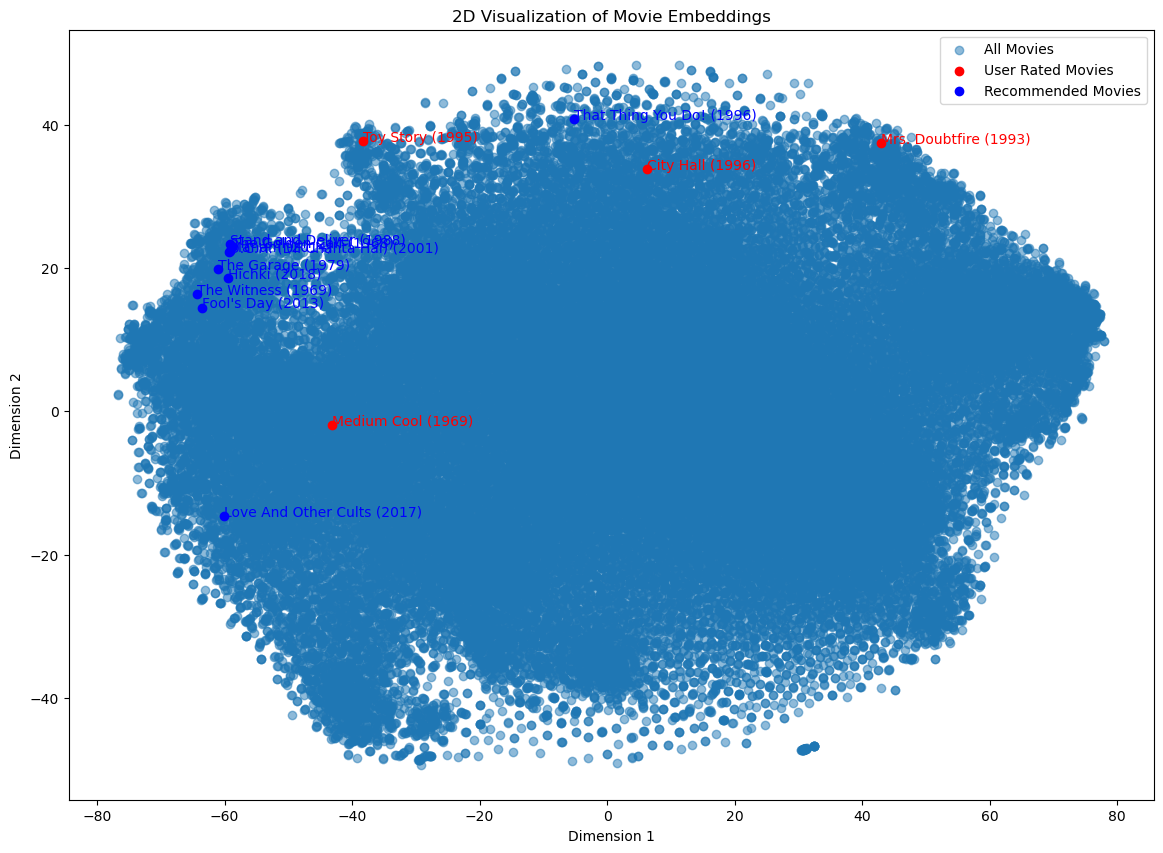

In [27]:
# Dimensionality reduction using TSNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(movie_embedding_matrix)

# Visualization
plt.figure(figsize=(14, 10))

# Plot all movie embeddings
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.5, label='All Movies')

# Highlight user-rated movies
user_rated_embeddings = embeddings_2d[new_user_movie_ids]
plt.scatter(user_rated_embeddings[:, 0], user_rated_embeddings[:, 1], color='red', label='User Rated Movies')

# Highlight recommended movies
recommended_movie_ids = recommended_movies_hybrid_movie_ids
recommended_embeddings = embeddings_2d[recommended_movie_ids]
plt.scatter(recommended_embeddings[:, 0], recommended_embeddings[:, 1], color='blue', label='Recommended Movies')

# Annotate user-rated movies
for i, movie_id in enumerate(new_user_movie_ids):
    plt.annotate(movie_id_to_title[movie_id], (user_rated_embeddings[i, 0], user_rated_embeddings[i, 1]), color='red')

# Annotate recommended movies
for i, movie_id in enumerate(recommended_movie_ids):
    plt.annotate(movie_id_to_title[movie_id], (recommended_embeddings[i, 0], recommended_embeddings[i, 1]), color='blue')

plt.title('2D Visualization of Movie Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()

In [26]:
# Recommendation source
def get_recommendation_source(movie_id):
    if movie_id in latent_factor_recommendations_movie_id:
        return 'Latent Factor Method'
    elif movie_id in recommended_movies_content.index:
        return 'Content-Based Method'
    else:
        return 'Hybrid Method'

# Display recommendation sources
for movie_id in recommended_movie_ids:
    movie_title = movie_id_to_title[movie_id]
    source = get_recommendation_source(movie_id)
    print(f"Recommendation for '{movie_title}' comes from: {source}")

Recommendation for 'The Garage (1979)' comes from: Latent Factor Method
Recommendation for 'Stand and Deliver (1988)' comes from: Hybrid Method
Recommendation for 'The Golden Calf (1968)' comes from: Hybrid Method
Recommendation for 'Hichki (2018)' comes from: Hybrid Method
Recommendation for 'The Witness (1969)' comes from: Hybrid Method
Recommendation for 'Fool's Day (2013)' comes from: Hybrid Method
Recommendation for 'That Thing You Do! (1996)' comes from: Hybrid Method
Recommendation for 'Manam (2014)' comes from: Latent Factor Method
Recommendation for 'Love And Other Cults (2017)' comes from: Hybrid Method
Recommendation for 'D.C.H. (Dil Chahta Hai) (2001)' comes from: Hybrid Method


In [40]:
def get_user_favorite_genres(user_ratings_df, movie_genres):
    genre_ratings = {}
    for _, row in user_ratings_df.iterrows():
        movie_id = row['movieId']
        rating = row['rating']
        genres = movie_genres.loc[movie_id]
        for genre in genres.index:
            if genres[genre] == 1:
                if genre not in genre_ratings:
                    genre_ratings[genre] = []
                genre_ratings[genre].append(rating)
    
    avg_genre_ratings = {genre: np.mean(ratings) for genre, ratings in genre_ratings.items()}
    favorite_genres = sorted(avg_genre_ratings, key=avg_genre_ratings.get, reverse=True)[:3]
    return favorite_genres

def explain_content_based_recommendations(recommended_movies, user_favorite_genres):
    explanations = []
    for movie_id in recommended_movies.index:
        title = movie_id_to_title[movie_id]
        genres = movie_genres.loc[movie_id].index[movie_genres.loc[movie_id] == 1].tolist()
        common_genres = set(genres).intersection(set(user_favorite_genres))
        explanation = f"'{title}' is recommended through content-based recommendation because it belongs to your favorite genres: {', '.join(common_genres)}."
        explanations.append((title, explanation))
    return explanations

def explain_latent_factor_recommendations(recommended_movies, user_ratings_df):
    explanations = []
    for movie_id in recommended_movies:
        title = movie_id_to_title[movie_id]
        similar_movies = new_user_ratings_df['movieId'].apply(lambda x: movie_id_to_title[x]).tolist()
        explanation = f"'{title}' is recommended through latent factor recommendation because it is similar to movies you rated highly: {', '.join(similar_movies)}."
        explanations.append((title, explanation))
    return explanations

def explain_hybrid_recommendations(hybrid_recommendations, user_favorite_genres, user_ratings_df):
    content_explanations = explain_content_based_recommendations(hybrid_recommendations, user_favorite_genres)
    latent_explanations = explain_latent_factor_recommendations(hybrid_recommendations['movieId'].tolist(), user_ratings_df)
    combined_explanations = []
    for content_exp, latent_exp in zip(content_explanations, latent_explanations):
        combined_explanations.append((content_exp[0], f"{content_exp[1]} Additionally, {latent_exp[1]}"))
    return combined_explanations

def group_and_output_explanations(hybrid_recommendations, user_favorite_genres, user_ratings_df):
    content_explanations = explain_content_based_recommendations(hybrid_recommendations, user_favorite_genres)
    latent_explanations = explain_latent_factor_recommendations(hybrid_recommendations['movieId'].tolist(), user_ratings_df)
    hybrid_explanations = explain_hybrid_recommendations(hybrid_recommendations, user_favorite_genres, user_ratings_df)
    
    grouped_explanations = {
        "Content-Based Recommendations": content_explanations,
        "Latent Factor Recommendations": latent_explanations,
        "Hybrid Recommendations": hybrid_explanations
    }
    
    for group, explanations in grouped_explanations.items():
        print(f"\n{group}:\n")
        for title, explanation in explanations:
            print(explanation)

In [41]:
user_favorite_genres = get_user_favorite_genres(new_user_ratings_df, movie_genres)
group_and_output_explanations(hyb_df, user_favorite_genres, new_user_ratings_df)


Content-Based Recommendations:

'Toy Story (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: Adventure, Children, Comedy.
'Jumanji (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: Adventure, Children.
'Grumpier Old Men (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: Comedy.
'Waiting to Exhale (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: Comedy.
'Father of the Bride Part II (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: Comedy.
'Heat (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: .
'Sabrina (1995)' is recommended through content-based recommendation because it belongs to your favorite genres: Comedy.
'Tom and Huck (1995)' is recommended through content-b